## Use DeepSORT instead of SORT for tracking

Based on [ZQPei's repository](https://github.com/ZQPei/deep_sort_pytorch), I replace SORT with DeepSort:

> Deep sort is basicly the same with sort but added a CNN model to extract features in image of human part bounded by a detector. [ZQPei](https://github.com/ZQPei/deep_sort_pytorch)

Other additions:

* Use a generator function (a programming construct) for for video analysis and detection per frame.
* This also allows for caching of intermediate steps

In [2]:
import cv2
from pathlib import Path
import numpy as np
from PIL import Image
import torch
from torchvision.io.video import read_video
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_pil_image
from torchvision.models.detection import retinanet_resnet50_fpn_v2, RetinaNet_ResNet50_FPN_V2_Weights
import tempfile   

In [3]:
source = Path('../DATASETS/VIRAT_subset_0102x')
videos = list(source.glob('*.mp4'))
#tmpdir = Path(tempfile.gettempdir()) / 'trajpred' #this doesn't survive reboot, change to a local cache dir
tmpdir = Path('.') / 'cache'
tmpdir.mkdir(exist_ok=True)


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

Based on code from: https://stackabuse.com/retinanet-object-detection-with-pytorch-and-torchvision/

In [5]:
weights = RetinaNet_ResNet50_FPN_V2_Weights.DEFAULT
model = retinanet_resnet50_fpn_v2(weights=weights, score_thresh=0.35)
model.to(device)
# Put the model in inference mode
model.eval()
# Get the transforms for the model's weights
preprocess = weights.transforms().to(device)

> The score_thresh argument defines the threshold at which an object is detected as an object of a class. Intuitively, it's the confidence threshold, and we won't classify an object to belong to a class if the model is less than 35% confident that it belongs to a class.

The result from a single prediction coming from `model(batch)` looks like:

```python
{'boxes': tensor([[5.7001e+02, 2.5786e+02, 6.3138e+02, 3.6970e+02],
         [5.0109e+02, 2.4508e+02, 5.5308e+02, 3.4852e+02],
         [3.4096e+02, 2.7015e+02, 3.6156e+02, 3.1857e+02],
         [5.0219e-01, 3.7588e+02, 9.7911e+01, 7.2000e+02],
         [3.4096e+02, 2.7015e+02, 3.6156e+02, 3.1857e+02],
         [8.3241e+01, 5.8410e+02, 1.7502e+02, 7.1743e+02]]),
 'scores': tensor([0.8525, 0.6491, 0.5985, 0.4999, 0.3753, 0.3746]),
 'labels': tensor([64, 64,  1, 64, 18, 86])}
```

In [6]:
%matplotlib inline


import pylab as pl
from IPython import display
from utils.timer import Timer
import pickle

def detect_persons(video_path: Path):
    """
    generator that returns detections as structure: [[x1,y1,x2,y2,score, label],...] for each frame
    """
    video = cv2.VideoCapture(str(video_path))


    cachefile = tmpdir / f"detections-all-{video_path.name}.pcl"
    if cachefile.exists():
        with cachefile.open('rb') as fp:
            print('use cache', cachefile)
            all_detections = pickle.load(fp)
            for detections in all_detections:
                ret, frame = video.read()
                yield frame, detections
    else:
        all_detections = []
        while True:
            ret, frame = video.read()
            
            if not ret:
                all_detections.append([])
                # print("Can't receive frame (stream end?). Exiting ...")
                break

            t = torch.from_numpy(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            # change axes of image loaded image to be compatilbe with torch.io.read_image (which has C,W,H format instead of W,H,C)
            t = t.permute(2, 0, 1)

            batch = preprocess(t)[None, :].to(device)
            # no_grad can be used on inference, should be slightly faster
            with torch.no_grad():
                predictions = model(batch)
            prediction = predictions[0] # we feed only one frame at the once

            mask = prediction['labels'] == 1 # if we want more than one: np.isin(prediction['labels'], [1,86])

            scores = prediction['scores'][mask]
            labels = prediction['labels'][mask]
            boxes = prediction['boxes'][mask]
            
            # TODO: introduce confidence and NMS supression: https://github.com/cfotache/pytorch_objectdetecttrack/blob/master/PyTorch_Object_Tracking.ipynb
            # (which I _think_ we better do after filtering)
            # alternatively look at Soft-NMS https://towardsdatascience.com/non-maximum-suppression-nms-93ce178e177c

            #  dets - a numpy array of detections in the format [[x1,y1,x2,y2,score, label],[x1,y1,x2,y2,score, label],...]
            detections = np.array([np.append(bbox, [score, label]) for bbox, score, label in zip(boxes.cpu(), scores.cpu(), labels.cpu())])
            
            all_detections.append(detections)
            
            yield frame, detections
    
        with cachefile.open('wb') as fp:
            pickle.dump(all_detections, fp)


In [7]:
def detect_persons_deepsort_wrapper(video_path: Path):
    """make detect_persons() compatible with
    deep_sort_realtime tracker by going from ltrb to ltwh and
    different nesting
    """
    for frame, detections in detect_persons(video_path):
        yield frame, [([d[0], d[1], d[2]-d[0], d[3]-d[1]], d[4], d[5]) for d in detections]

In [8]:
from deep_sort_realtime.deepsort_tracker import DeepSort

def track_video(video_path: Path) -> dict:
    # mot_tracker = Sort()
    mot_tracker = DeepSort(max_age=5)
    
    for frame_nr, (frame, detections) in enumerate(detect_persons(video_path)):
        detections = [([d[0], d[1], d[2]-d[0], d[3]-d[1]], d[4], d[5]) for d in detections]
        
        # tracks structure: [[x1,y1,x2,y2,score, obj_id],...]
        # tracks = mot_tracker.update(detections)
        tracks = mot_tracker.update_tracks(detections, frame=frame)
        # print(tracks)

        # now convert back to boxes and labels
        # # print(tracks)
        # boxes = np.array([t.to_ltwh() for t in tracks])
        # # initialize empty with the necesserary dimensions for drawing_bounding_boxes glitch
        # t_boxes = torch.from_numpy(boxes) if len(boxes) else torch.Tensor().new_empty([0, 6])
        # labels = [str(int(t.track_id)) for t in tracks]
        # print(t_boxes, boxes, labels)

        for track in tracks:
            yield track
            

    #     display.clear_output(wait=True)

# for track in  track_video(Path("../DATASETS/VIRAT_subset_0102x/VIRAT_S_010200_00_000060_000218.mp4")):
#     print(track)


Interestingly, the Deepsort tracker does not keep the history of the track, so I needed to alter the code a little: I do not append the track itself, but collect `track.to_ltwh()` for every frame.

In [9]:
def track_videos(video_paths: list[Path]) -> dict:
    """
    returns tracked instances as dict with lists:
      {'obj_id': [ [x1, y1, x2, y2, obj_id,  obj_class ], ...]}
    """
    # collect instances of all videos with unique key
    video_paths = list(video_paths)
    tracked_instances = {}
    timer = Timer()
    for i, p in enumerate(video_paths):
        print(f"{i}/{len(video_paths)}: {p}")

        cachefile = tmpdir / (p.name + '-deepsort.pcl')
        if cachefile.exists():
            print('\tLoad pickle')
            with cachefile.open('rb') as fp:
             new_instances = pickle.load(fp)
        else:
            #continue # to quickly test from cache
            new_instances = {}
            timer.tic()
            for track in track_video(p):
                track_id = f"{i}_{str(int(track.track_id))}"
                # track = np.append(track, i) # append video id, for disambiguation later
                if track_id not in new_instances:
                    new_instances[track_id] = []
                new_instances[track_id].append(track.to_ltwh())
            with cachefile.open('wb') as fp:
                pickle.dump(new_instances, fp)
            print(" time for video: ", timer.toc())
        tracked_instances.update(new_instances)
        
    return tracked_instances

In [10]:
tracked_instances = track_videos(videos)
len(tracked_instances)

0/76: ../DATASETS/VIRAT_subset_0102x/VIRAT_S_010200_00_000060_000218.mp4


## Project / Homography

Now that all trajectories are captured (for a single video), these can then be projected onto a flat surface by [homography](https://en.wikipedia.org/wiki/Homography_(computer_vision)). The necessary $H$ matrix is already provided by VIRAT in the [homographies folder](https://data.kitware.com/#folder/56f581c88d777f753209c9d2) of their online data repository.

In [10]:

homography = list(source.glob('*img2world.txt'))[0]
H = np.loadtxt(homography, delimiter=',')



The homography matrix helps to transform points from image space to a flat world plane. The `README_homography.txt` from VIRAT describes:

> Roughly estimated 3-by-3 homographies are included for convenience. 
> Each homography H provides a mapping from image coordinate to scene-dependent world coordinate.
>   
> [xw,yw,zw]' = H*[xi,yi,1]'
> 
> xi: horizontal axis on image with left top corner as origin, increases right.
> yi: vertical axis on image with left top corner as origin, increases downward.
> 
> xw/zw: world x coordinate
> yw/zw: world y coordiante

(1200, 900)


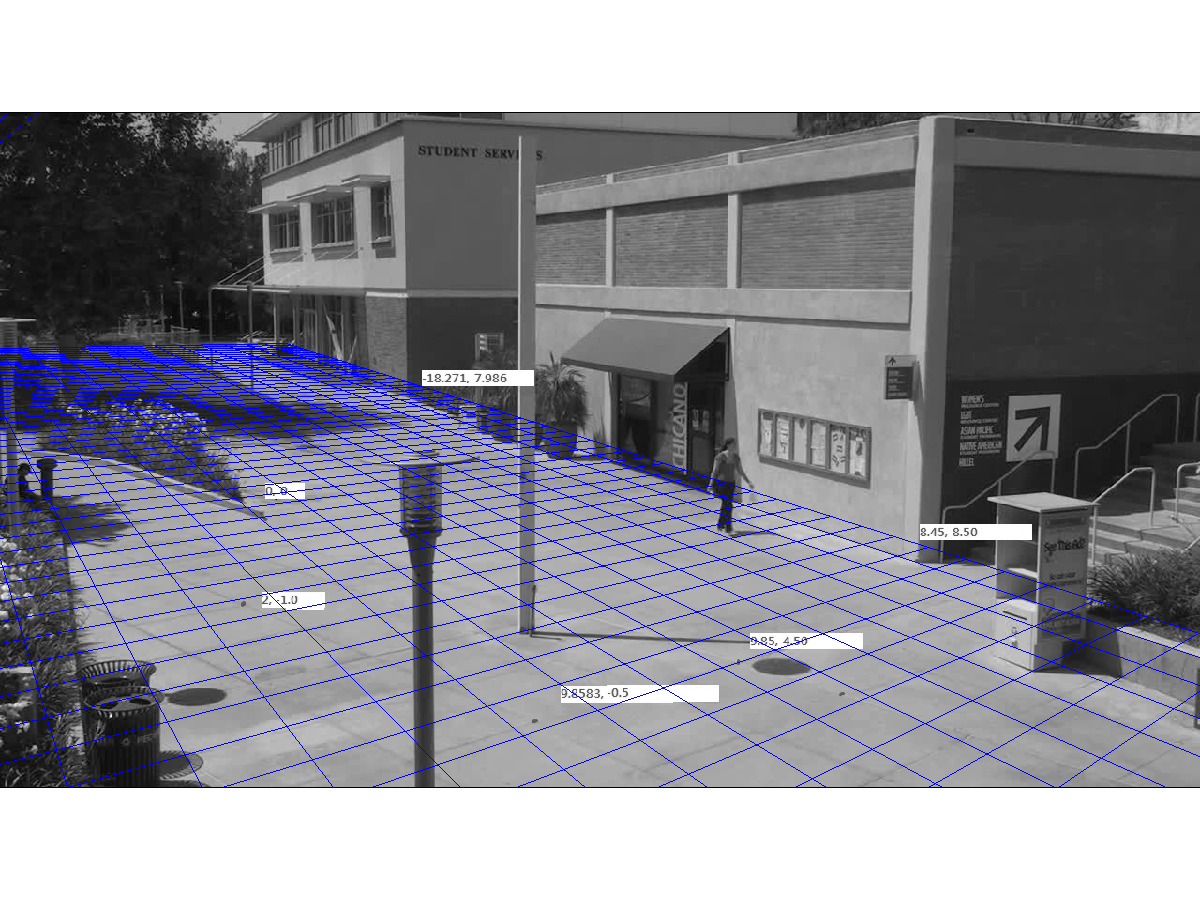

In [11]:
print(Image.open("../DATASETS/VIRAT_subset_0102x/VIRAT_0102_homography_img2world.png").size)
Image.open("../DATASETS/VIRAT_subset_0102x/VIRAT_0102_homography_img2world.png")


{'mean': array([2.21015548e+02, 2.41720687e+02, 4.25961370e-01, 2.38039405e+01,
       8.98401171e-02, 2.16254966e-02, 4.59794012e-07, 4.23068743e-02]), 'covariance': array([[1.81834256e+01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.51804145e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.81834256e+01, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.51804145e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.53354367e-03, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 2.86545590e-08, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.81834256e+01,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.51804145e+00],
       [1.51804145e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        3.13885555e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.51804145e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 3.13885555e-

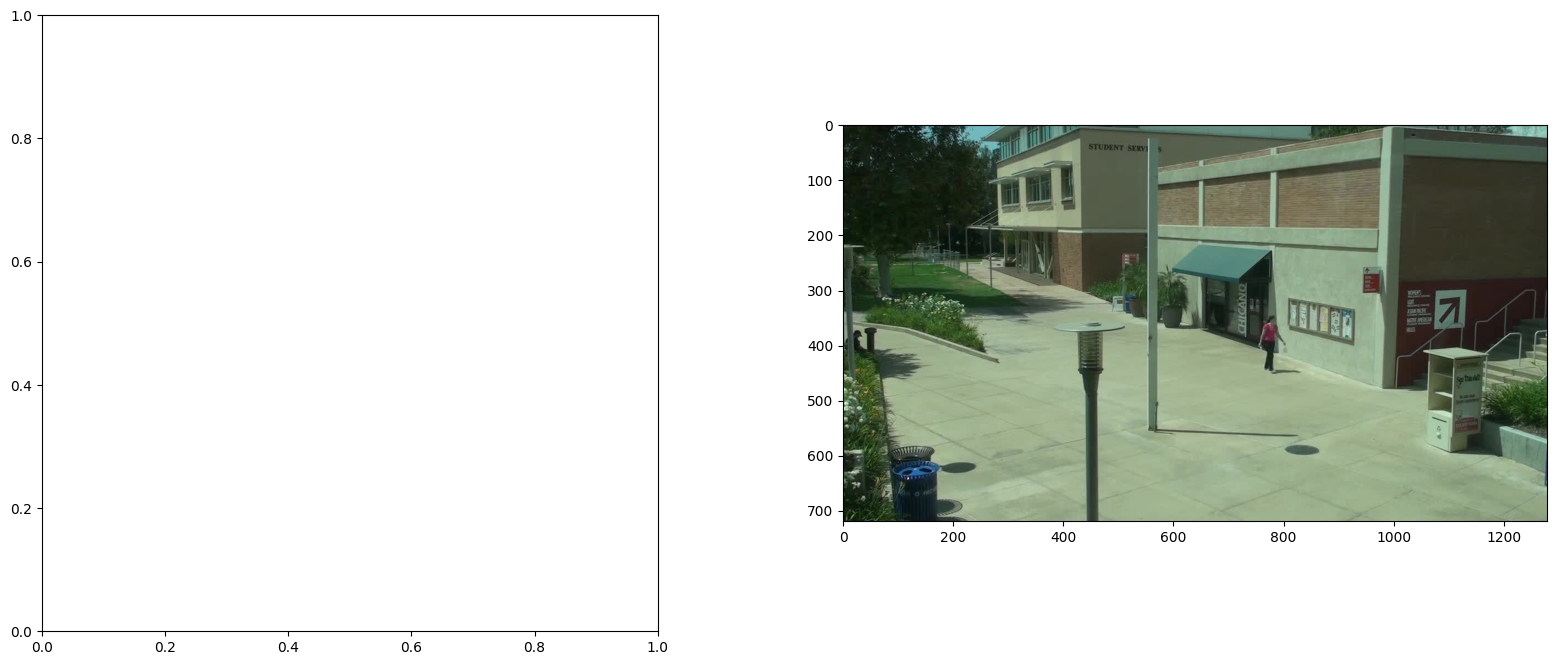

In [22]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(20,8))
ax1, ax2 = fig.subplots(1,2)

ax1.set_aspect(1)
ax2.imshow(Image.open("../DATASETS/VIRAT_subset_0102x/VIRAT_S_0102.jpg"))

for i, tracks in enumerate(tracked_instances.values()):
    bboxes = [track.to_ltrb() for track in tracks]
    traj = np.array([[[0.5 * (det[0]+det[2]), det[3]]] for det in bboxes])
    projected_traj = cv2.perspectiveTransform(traj,H)
    # plt.plot(projected_traj[:,0])
    ax1.plot(projected_traj[:,:,0].reshape(-1), projected_traj[:,:,1].reshape(-1))
    ax2.plot(traj[:,:,0].reshape(-1), traj[:,:,1].reshape(-1))
    
plt.show()

One of the things that stands out from these plots in the detections at the edges of the image. In particular the bottom edge (on the right-hand side in the projected image) is visible. As the 'anchor' of the person detection is follows the detection bounding box, which is no longer moving, but growing or shrinking at the edge.

Let's apply a simple filter to ditch the detections close to the edge.

In [11]:
def filter_edges(tracked_instances):
    filtered_tracks =  {}
    for track_id in tracked_instances:
        bboxes = tracked_instances[track_id]
        track = list(filter(lambda bbox: bbox[1] < 710 and bbox[3] < 710, bboxes))
        if len(track):
            filtered_tracks[track_id] = track
    return filtered_tracks

filtered_tracks = filter_edges(tracked_instances)

# validate it works:
bbox_count = sum([len(t) for t in tracked_instances.values()])
bbox_count_filtered = sum([len(t) for t in filtered_tracks.values()])

print(f"removed {((bbox_count-bbox_count_filtered)/bbox_count)*100:.2f}% of bounding boxes")

removed 2.87% of bounding boxes


Below we plot the filtered trajectories

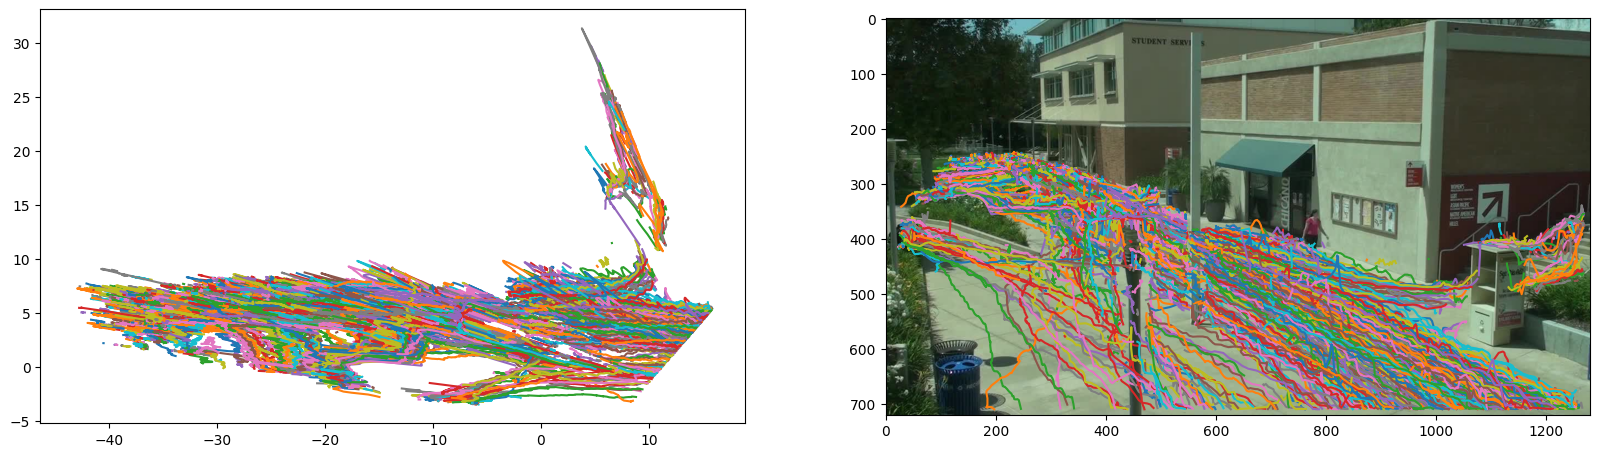

In [77]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(20,8))
ax1, ax2 = fig.subplots(1,2)

ax1.set_aspect(1)
ax2.imshow(Image.open("../DATASETS/VIRAT_subset_0102x/VIRAT_S_0102.jpg"))

for bboxes in filtered_tracks.values():
    traj = np.array([[[0.5 * (det[0]+det[2]), det[3]]] for det in bboxes])
    projected_traj = cv2.perspectiveTransform(traj,H)
    # plt.plot(projected_traj[:,0])
    ax1.plot(projected_traj[:,:,0].reshape(-1), projected_traj[:,:,1].reshape(-1))
    ax2.plot(traj[:,:,0].reshape(-1), traj[:,:,1].reshape(-1))
    
plt.show()

What if the projection is a heatmap of where people are? For this I reuse the above plot and apply blurring effects of pyplot from [their documentation](https://matplotlib.org/stable/gallery/misc/demo_agg_filter.html)

Note that person tracking would not really be necessary for this to work. Detection on a frame-by-frame basis would be sufficient to achieve something similar.

The plots below use two slightly different ways of plotting. The first shows the tracks as transparent lines, the second plots the detections as points. This last way of plotting would not stricktly require the tracking as only individual detections are aggregrated.

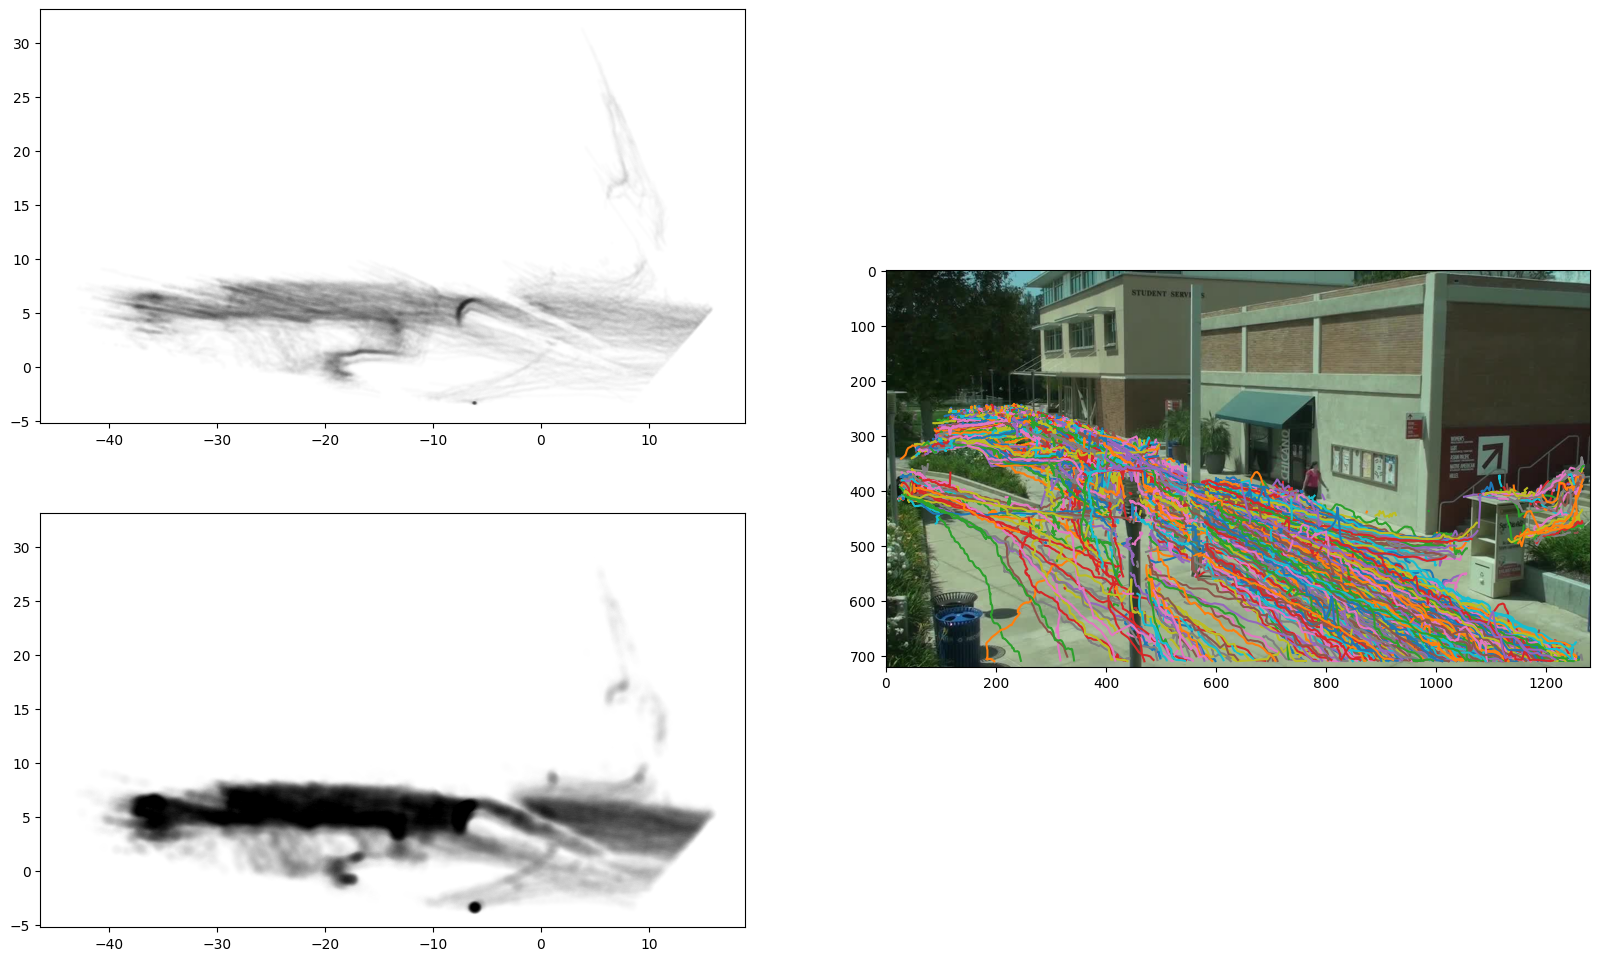

In [78]:
from matplotlib import gridspec
import matplotlib.cm as cm
import matplotlib.transforms as mtransforms
from matplotlib.colors import LightSource
from matplotlib.artist import Artist


def smooth1d(x, window_len):
    # copied from https://scipy-cookbook.readthedocs.io/items/SignalSmooth.html
    s = np.r_[2*x[0] - x[window_len:1:-1], x, 2*x[-1] - x[-1:-window_len:-1]]
    w = np.hanning(window_len)
    y = np.convolve(w/w.sum(), s, mode='same')
    return y[window_len-1:-window_len+1]


def smooth2d(A, sigma=3):
    window_len = max(int(sigma), 3) * 2 + 1
    A = np.apply_along_axis(smooth1d, 0, A, window_len)
    A = np.apply_along_axis(smooth1d, 1, A, window_len)
    return A


class BaseFilter:

    def get_pad(self, dpi):
        return 0

    def process_image(self, padded_src, dpi):
        raise NotImplementedError("Should be overridden by subclasses")

    def __call__(self, im, dpi):
        pad = self.get_pad(dpi)
        padded_src = np.pad(im, [(pad, pad), (pad, pad), (0, 0)], "constant")
        tgt_image = self.process_image(padded_src, dpi)
        return tgt_image, -pad, -pad



class GaussianFilter(BaseFilter):
    """Simple Gaussian filter."""

    def __init__(self, sigma, alpha=0.5, color=(0, 0, 0)):
        self.sigma = sigma
        self.alpha = alpha
        self.color = color

    def get_pad(self, dpi):
        return int(self.sigma*3 / 72 * dpi)

    def process_image(self, padded_src, dpi):
        tgt_image = np.empty_like(padded_src)
        tgt_image[:, :, :3] = self.color
        tgt_image[:, :, 3] = smooth2d(padded_src[:, :, 3] * self.alpha,
                                      self.sigma / 72 * dpi)
        return tgt_image

gauss = GaussianFilter(2)

fig = plt.figure(figsize=(20,12))


# Create 2x2 sub plots
gs = gridspec.GridSpec(2, 2)

# (ax1, ax2), (ax3, ax4) = fig.subplots(2,2)
ax1 = fig.add_subplot(gs[0,0])
ax3 = fig.add_subplot(gs[1,0])
ax2 = fig.add_subplot(gs[:,1])

ax1.set_aspect(1)
ax3.set_aspect(1)

# show the image from the dataset on ax2
ax2.imshow(Image.open("../DATASETS/VIRAT_subset_0102x/VIRAT_S_0102.jpg"))

for bboxes in filtered_tracks.values():
    traj = np.array([[[0.5 * (det[0]+det[2]), det[3]]] for det in bboxes])
    projected_traj = cv2.perspectiveTransform(traj,H)
    # plt.plot(projected_traj[:,0])
    
    # option1: draw the tracks as lines
    line, = ax1.plot(projected_traj[:,:,0].reshape(-1), projected_traj[:,:,1].reshape(-1), color=(0,0,0,0.05))
    line.set_agg_filter(gauss)
    line.set_rasterized(True) # "to suport mixed-mode renderers"

    # option2: draw the tracks merely as individual detection points (for which no tracking would have been necessary)
    points = ax3.scatter(projected_traj[:,:,0].reshape(-1), projected_traj[:,:,1].reshape(-1), color=(0,0,0,0.01))
    points.set_agg_filter(gauss)
    points.set_rasterized(True) # "to suport mixed-mode renderers"

    ax2.plot(traj[:,:,0].reshape(-1), traj[:,:,1].reshape(-1))
    
plt.show()

For the quickest way to test trajectory prediciton, export the tracks to the common format (as used by e.g. Social-GAN). A `txt`-file with `frameNR pedestrianID, x, y`

In [94]:
def convert_to_pedestrian_id(pid: str) -> int:
    return int(pid.replace('_', ''))

# make sure no duplicates happen in the conversion
assert len(filtered_tracks.keys()) == np.unique([convert_to_pedestrian_id(k) for k in filtered_tracks.keys()]).shape[0]

In [123]:
from math import ceil


nr_videos = max([ b[0][7] for  b in filtered_tracks.values()] )
nr_val = ceil(nr_videos/4)
nr_train = nr_videos - nr_val
print(nr_val, nr_train)

19 56.0


In [125]:
frame_peds_train = []
frame_peds_val = []

for track_id, bboxes in filtered_tracks.items():
    ped_id = convert_to_pedestrian_id(track_id)
    traj = np.array([[[0.5 * (det[0]+det[2]), det[3]]
    ] for det in bboxes])
    projected_traj = cv2.perspectiveTransform(traj,H)
    # len(projected_traj), len([b[6] for b in bboxes]))
    frame_pedestrians = [[bboxes[i][6] + bboxes[i][7] * 1000, ped_id, point[0][0], point[0][1]] for i, point in enumerate(projected_traj)]

    if bboxes[0][7] < nr_train:
        frame_peds_train.extend(frame_pedestrians)
    else:
        frame_peds_val.extend(frame_pedestrians)

frame_peds_train.sort()
frame_peds_val.sort()

In [126]:
len(frame_peds_train), len(frame_peds_val)

(268320, 79913)

In [127]:
frame_peds_val[:10]

[[56000.0, 5646342, 9.635322232960501, 5.007763488524792],
 [56000.0, 5646343, 10.242926638190253, 6.041340117572103],
 [56000.0, 5646344, -24.361324332610195, 6.360463121093617],
 [56000.0, 5646345, -36.33278268357405, 6.5426289049817115],
 [56001.0, 5646342, 9.655806533781627, 4.999777317969075],
 [56001.0, 5646343, 10.261907375159826, 6.057640070999422],
 [56001.0, 5646344, -24.382238557678683, 6.385945927025485],
 [56001.0, 5646345, -36.360648356525196, 6.54482638578711],
 [56001.0, 5646346, -37.88799589844155, 5.549882189065968],
 [56002.0, 5646342, 9.732648082414663, 4.998398827649513]]

In [128]:
from pathlib import Path

base_path = Path('datasets/VIRAT_subset')
train_path = base_path / 'train'
val_path = base_path / 'val'

train_file = train_path / 'VIRAT_train.txt'
val_file = val_path / 'VIRAT_test.txt'

train_path.mkdir(parents=True, exist_ok=True)
val_path.mkdir(parents=True, exist_ok=True)

In [129]:
comment = "See https://git.rubenvandeven.com/security_vision/trajpred/"
np.savetxt(train_file, frame_peds_train, delimiter=' ', fmt='%1.2f')
np.savetxt(val_file, frame_peds_val, delimiter=' ', fmt='%1.2f')

In [130]:
print('average track lenght')
sum([len(t) for t in filtered_tracks.values()])/len(filtered_tracks)

average track lenght


58.9127051260362

In [1]:
for track_id, bboxes in filtered_tracks.items():
  traj = np.array([[[0.5 * (det[0]+det[2]), det[3]]
    ] for det in bboxes])
  projected_traj = cv2.perspectiveTransform(traj,H)
  print(projected_traj)
  break

NameError: name 'filtered_tracks' is not defined